# Building a Movie Recommendation Engine Using Collaborative Filtering and Content-Based Filtering.

This project focuses on creating an intelligent movie recommendation system that combines two widely used machine learning techniques: Collaborative Filtering and Content-Based Filtering. The system will help users discover and receive movie recommendations tailored to their personal preferences based on movie ratings and other relevant data. I will build our own recommendation system using the [MovieLens](https://movielens.org/home) dataset in Python.

Dự án này tập trung vào việc xây dựng một hệ thống gợi ý phim thông minh, kết hợp giữa hai phương pháp phổ biến trong học máy: Collaborative Filtering và Content-Based Filtering. Hệ thống sẽ giúp người dùng tìm kiếm và nhận đề xuất phim phù hợp với sở thích cá nhân dựa trên các dữ liệu về đánh giá phim. Tôi sẽ xây dựng hệ thống gợi ý phim dựa trên [MovieLens](https://movielens.org/home) dataset bằng Python. 

### What is MovieLens?

MovieLens is a recommender system that was developed by GroupLens, a computer science research lab at the University of Minnesota. It recommends movies to its users based on their movie ratings. It is also a dataset that is widely used in research and teaching contexts. 

MovieLens là một hệ thống gợi ý được phát triển bởi nhóm nghiên cứu GroupLens tại Đại học Minnesota, nhằm đưa ra các đề xuất phim dựa trên những đánh giá mà người dùng đã thực hiện. Đây cũng là một bộ dữ liệu nổi tiếng được sử dụng rộng rãi trong nghiên cứu và giảng dạy về hệ thống gợi ý.

### Project Outline

This project is broken down into 7 steps:

1. Importing the dependnecies
1. Loading the data
1. Exploratory data analysis 
1. Data pre-processing
1. Collaborative filtering using k-Nearest Neighbors
1. Content-based filtering
1. Dimensionality reduction with matrix factorization

### Import Dependencies 
I am using [pandas.DataFrame](http://pandas.pydata.org/pandas-docs/version/0.19/generated/pandas.DataFrame.html) to represent the data. I will visualize the data with [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/).

Tôi sẽ sử dụng cấu trúc [pandas.DataFrame](http://pandas.pydata.org/pandas-docs/version/0.19/generated/pandas.DataFrame.html) để biểu diễn dữ liệu và trực quan hóa dữ liệu bằng thư viện [matplotlib](https://matplotlib.org/) và [seaborn](https://seaborn.pydata.org/)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data
I will download a small version of the MovieLens dataset. You can download the data [here](https://grouplens.org/datasets/movielens/). \
Tôi sẽ sử dụng verson rút gọn của bộ dữ liệu MovieLens.

And load the datasets ratings.csv and movies.csv \
Và tải dữ liệu của file rating.csv và movies.csv

In [5]:
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Exploratory Data Analysis

In [9]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movies: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movies: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


#### What is the distribution of movie ratings?
Các đánh giá phim được phân phối như thế nào?

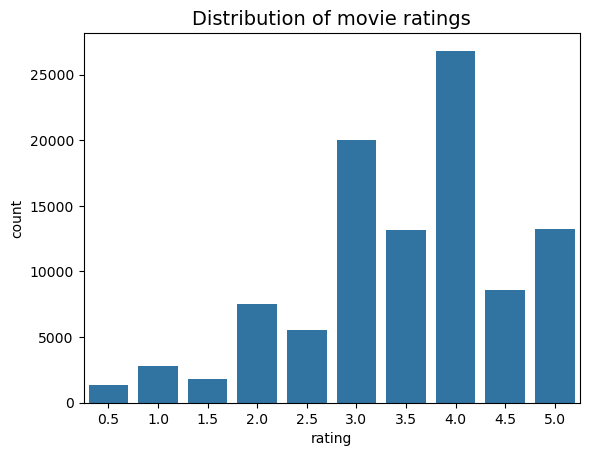

In [11]:
sns.countplot(x = 'rating', data = ratings)
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [12]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

Mean global rating: 3.5.


In [13]:
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean rating per user: 3.66.


#### Which movies are most frequently rated?

In [15]:
ratings['movieId'].value_counts()[0:10]

movieId
356     329
318     317
296     307
593     279
2571    278
260     251
480     238
110     237
589     224
527     220
Name: count, dtype: int64

The result shows us that movieId 365 has 329 ratings, but we cannot know what the movie's title is. Therefore, we can get the movie's title by merging (joining) the 'movies' dataframe with the 'ratings' dataframe. \
Kết quả của câu lệnh chỉ cho ta thấy được số ratings của các movieId mà không có tên của các bộ phim. Vì vậy chúng ta cần phải kết hợp 2 dataframe 'movies' và 'ratings' lại với nhau.

In [17]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64

Forrest Gump, The Shawshank Redemption, and Pulp Fiction have the most ratings.

#### What are the lowest and highest rated movies?

Which movie has the lowest and highest average rating? \
Đâu là bộ phim có rating trung bình thấp nhất và cao nhất?

In [21]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
# mean_ratings
movies[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


'Gypsy' has the lowest average rating. \
'Gypsy' là bộ phim có rating trung bình thấp nhất.

In [23]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


How many ratings does 'Lamerica' have?

In [25]:
ratings[ratings['movieId'] == highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


'Lamerica' may be the highest rated movie, but it only has 2 ratings. A better approach for evaluating movie popularity is to do look at the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average). \
Mặc dù, 'Lamerica' là phim có điểm đánh giá cao nhất, nhưng nó chỉ có 2 đánh giá. Một phương pháp tốt hơn để đánh giá độ phổ biết của bộ phim là sử dụng  [Trung bình Bayesian](https://en.wikipedia.org/wiki/Bayesian_average).

#### Bayesian Average

In this case, Bayesian Average is defined as:

$r_{i} = \frac{C \times m + \Sigma{\text{reviews}}}{C+N}$

where $C$ represents our confidence, $m$ represents our prior, and $N$ is the total number of reviews for movie $i$. 
* In this case, our prior $m$ will be the average rating across all movies.
* By defintion, C represents "the typical data set size". $C$ will be the average number of ratings for a given movie. 

Trong đó: \
$r_{i}$ là giá trị trung bình của bộ phim. \
$C$ đại diện cho mức độ tin cậy (confidence). $C$ là số lượng trung bình của các đánh giá cho tất cả bộ phim trong tập dữ liệu. \
$m$ là giá trị trung bình trước đó của tất cả bộ phim (hay còn gọi là prior). \
$\Sigma{\text{reviews}}$ là tổng số điểm đánh giá (hoặc tổng các đánh giá) cho bộ phim $i$. \
$N$ là số lượng tổng các đánh giá của bộ phim $i$

In [28]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [29]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


Let's test our 'bayesian_avg' function out on 'Lameriaca': \
Áp dụng hàm 'bayesian_avg' cho bộ phim 'Lamerica'

In [31]:
lamerica = pd.Series([5,5]) # the lamerica's two ratings
bayesian_avg(lamerica)

3.543

Lamerica's average Bayesian rating is 3.5. \
Vậy rating trung bình của phim Lamerica chỉ là 3.5

Let's now apply `bayesian_avg` to all movies in our dataset. \
Áp dụng hàm 'bayesian_avg' cho toàn bộ các bộ phim trên tập dữ liệu.

In [33]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [34]:
movie_stats.head()

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.891
1,2,110,3.431818,3.417
2,3,52,3.259615,3.260
3,4,7,2.357143,2.898
4,5,49,3.071429,3.105


In [35]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values(by='bayesian_avg', ascending=False)

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"
...,...,...,...,...,...
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1372,1882,33,1.954545,2.267,Godzilla (1998)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)


Using the Bayesian average, we see that 'Shawshank Redemption', 'The Godfather', and 'Fight Club' are the most highly rated movies. This result makes much more sense since these movies are critically acclaimed films. \
Sau khi sử dụng Trung bình Bayesian, chúng ta thấy được 'Shawshank Redemption', 'The Godfather', và 'Fight Club' là 3 bộ phim được đánh giá cao nhất. Kết quả này hoàn toàn hợp lý bởi vì những bộ phim này cũng được giới phê bình đánh giá cao.

In [37]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


With Bayesian averaging, it looks like 'Speed 2: Cruise Control, Battlefield Earth, and 'Godzilla' are the worst rated movies. \
Ta cũng thấy được rằng, 'Speed 2: Cruise Control, Battlefield Earth, và 'Godzilla' là 3 bộ phim được đánh giá thấp nhất.

#### A Glimpse at Movie Genres


In [40]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


The movies dataset needs to be cleaned in two ways:

- 'genres' is expressed as a string with a pipe `|` separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
- 'title' currently has (year) appended at the end. We will extract year from each title string and create a new column for it.

Bộ dữ liệu movies cần được làm sạch 2 thứ:

- 'genres' đang được biểu diễn dưới dạng một chuỗi ký tự với dấu `|` ngăn cách mỗi thể loại phim. Ta sẽ xử lý chuỗi này thành một danh sách, giúp việc phân tích trở nên dễ dàng hơn.
- 'title' đang có (year) được thêm vào ở cuối mỗi tên phim. Ta sẽ tách các năm ra khỏi tên và tạo một cột riêng dành cho (year).

In [42]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


Now we can explore the data in the genres column. \
Giờ ta đã có thể khám phá dữ liệu của genres

##### How many genre are there?

In [45]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [46]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


Visualize genre popularity with a barplot. \
Trực quan hóa mức độ phổ biến của các thể loại phim với biểu đồ cột.

In [48]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre','count']
genre_frequency_df

,genre,count
0,Adventure,1263
1,Animation,611
2,Children,664
3,Comedy,3756
4,Fantasy,779
5,Romance,1596
6,Drama,4361
7,Action,1828
8,Crime,1199
9,Thriller,1894


/var/folders/54/z68l1r457kn2b08vjsx3s6rw0000gn/T/ipykernel_5646/2483692501.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='genre',y='count', data=genre_frequency_df.sort_values(by='count',ascending=False), palette = 'crest')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Drama'),
  Text(1, 0, 'Comedy'),
  Text(2, 0, 'Thriller'),
  Text(3, 0, 'Action'),
  Text(4, 0, 'Romance'),
  Text(5, 0, 'Adventure'),
  Text(6, 0, 'Crime'),
  Text(7, 0, 'Sci-Fi'),
  Text(8, 0, 'Horror'),
  Text(9, 0, 'Fantasy'),
  Text(10, 0, 'Children'),
  Text(11, 0, 'Animation'),
  Text(12, 0, 'Mystery'),
  Text(13, 0, 'Documentary'),
  Text(14, 0, 'War'),
  Text(15, 0, 'Musical'),
  Text(16, 0, 'Western'),
  Text(17, 0, 'IMAX'),
  Text(18, 0, 'Film-Noir'),
  Text(19, 0, '(no genres listed)')])

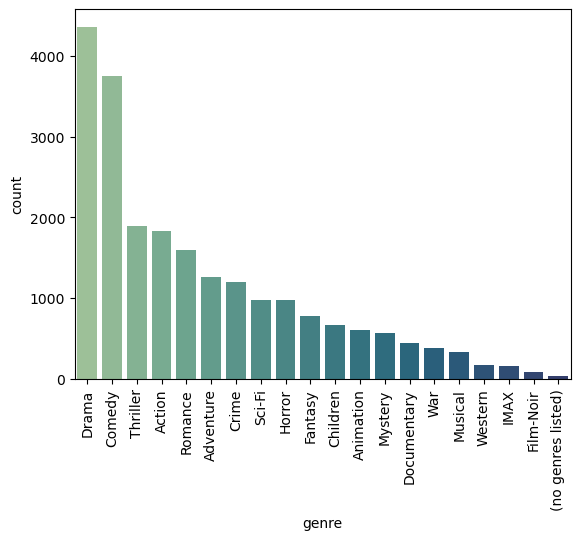

In [49]:
sns.barplot(x='genre',y='count', data=genre_frequency_df.sort_values(by='count',ascending=False), palette = 'crest')
plt.xticks(rotation=90)

### Data Pre-processing

We are going to use a technique called collaborative filtering to generate recommendations for users. This technique is based on the premise that similar people like similar things. \
Ta sẽ sử dụng kĩ thuật gọi là collaborative filtering để tạo ra những đề xuất cho người dùng. Kĩ thuật này dựa trên giả thuyết rằng những người tương tự sẽ thích những thứ tương tự .

The first step is to transform our data into a user-item matrix, also known as a "utility" matrix. In this matrix, rows represent users and columns represent movies. The beauty of collaborative filtering is that it doesn't require any information about the users or the movies user to generate recommendations. \
Bước đầu tiên, chúng ta phải chuyển bộ dữ liệu của chúng ta thành một ma trận user-item, hay còn được gọi là ma trận "utility". Trong ma trận này, các dòng sẽ đại diện cho users và các cột sẽ đại diện cho movies. Điểm mạnh của colaborative filtering là nó không yêu cầu bất kỳ thông tin nào về người dùng hoặc các bộ phim để tạo ra đề xuất.

<img src="https://i.postimg.cc/jd76pPtS/userId.png" width=50%/>

The 'create_X() function outputs a sparse matrix $X$ with four mapper dictionaries:

- **user_mapper**: maps user id to user index
- **movie_mapper**: maps movie id to movie index
- **user_inv_mapper**: maps user index to user id
- **movie_inv_mapper**: maps movie index to movie id

We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

Our $X$ (user-item) matrix is a [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html) which stores the data sparsely.


Hàm 'create_X()' sẽ trả về một ma trận thưa (sparse matrix) cùng với bốn từ điển (mapping dictionaries):

- **user_mapper**: từ điển này map user id đến user index (chỉ số người dùng trong ma trận).
- **movie_mapper**: từ điển này map movie id đến movie index (chỉ số bộ phim trong ma trận).
- **user_inv_mapper**: từ điển nảy map ngược lại từ user index đến user id, nghĩa là từ chỉ số người dùng trong ma trận quay lại id người dùng gốc.
- **movie_inv_mapper**: từ điển nảy map ngược lại từ movie index đến movie id, nghĩa là từ chỉ số bộ phim trong ma trận quay lại id bộ phim gốc.

Các từ điển này rất quan trọng vì chúng giúp xác định dòng và cột nào trong ma trận utility tương ứng với ID người dùng và ID bộ phim.

In [52]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [53]:
X.shape

(610, 9724)

Our X matrix contains 610 users and 9724 movies

#### Evaluating sparsity

Here, we calculate sparsity by dividing the number of stored elements by total number of elements. The number of stored (non-empty) elements in our matrix ([nnz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.nnz.html)) is equivalent to the number of ratings in our dataset.

Ở đây, chúng ta sẽ tính toán độ thưa bằng cách chia số lượng phần tử đã được lưu trữ cho tổng số phần tử. Số lượng phần tử đã được lưu trữ (không rỗng) trong ma trận của ta ([nnz](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.nnz.html)) sẽ tương đương với số lượng đánh giá trong bộ dữ liệu.

In [56]:
n_total = X.shape[0]*X.shape[1] # = 610 * 9724
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


csr_matrix.nnz counts the stored values in our sparse matrix. The rest of our cells are empty. \
csr_matrix.nnz đếm số lượng giá trị đã được lưu trữ. Các ô còn lại trong ma trận đều rỗng.

The **cold start problem** is when there are new users and movies in our matrix that do not have any ratings. In our Movielens dataset, all users and movies have at least one rating but in general, it's useful to check which users and movies have few interactions. \
Hiện tượng **cold start problen** xảy ra khi có người dùng và bộ phim mới trong ma trận mà không có bất kỳ đánh giá nào. Trong bộ dữ liệu của Movielens, tất cả người dùng và bộ phim đều có ít nhất một đánh giá, nhưng nhìn chung, việc kiểm tra những người dùng và bộ phim có ít tương tác là hữu ích.

In [58]:
#number rating per user
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

610

In [59]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [60]:
#number rating per movie
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

9724

In [61]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


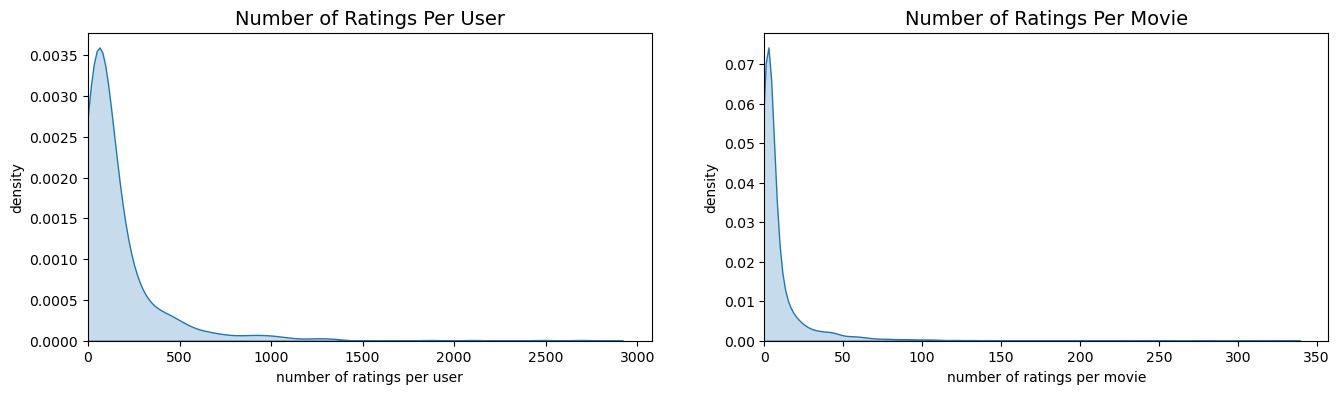

In [62]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

### Collaborative filtering using k-Nearest Neighbors

We are going to find the $k$ movies that have the most similar user engagement vectors for movie $i$. \
Ta sẽ đi tìm $k$ bộ phim có mức độ tương tác của người dùng giống nhất với bộ phim $i$.

In [64]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbors for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

`find_similar_movies()` takes in a `movieId` and `X` matrix, and outputs a list of $k$ movies that are similar to the `movieId` of interest. \
Đầu vào của hàm `find_similar_movies()` sẽ là `movieId` và ma trận `X`, và đầu ra sẽ là danh sách $k$ bộ phim tương tự với `movieId` bộ phim mà ta muốn.

In [66]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

`find_similar_movies()` returns a list of `movieId`'s that are most similar to your movie of interest. Let's convert these id's to titles so that we can interpret our results. To make things easier, we will create a dictionary that maps `movieId` to `title`. \
Kết quả của hàm `find_similar_movies()` cho ta danh sách các `movieId`'s có nhiều tương đồng nhất với bộ phim cần lấy đề xuất. Giờ chúng ta sẽ chuyển những id này này tên các bộ phim để có thể thấy kết quả một cách rõ ràng hơn. Ta sẽ tạo một dictionary và map `movieId` với `title` của bộ phim

In [68]:
movie_titles = dict(zip(movies['movieId'], movies['title']))
movie_titles

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (199

In [69]:
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


The results above show the 10 movies that are most similar to Toy Story. Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not used in this approach. \
Kết quả cho ra 10 bộ phim có nhiều tương đồng nhất với Toy Story. Lưu ý rằng các đề xuất này chỉ dựa trên đánh giá của người dùng đối với bộ phim. Các đặc trưng của phim như thể loại không được sử dụng trong phương pháp này.

### Handling the cold-start problem

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system. This is called the **cold start problem**. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features. \
Collaborative filtering hoàn toàn dựa vào sự đánh giá giữa người dùng và các bộ phim trong ma trận utility. Vấn đề của phương pháp này chính là với những người dùng hoặc bộ phim mới, không có đánh giá nào, sẽ bị loại khỏi hệ thống đề xuất. Vẫn đề này được gọi là **cold start problem**. Và Content-based filtering là một cách để giải quyết vấn đề bằng cách tạo ra các đề xuất dựa trên các đặc trưng của người dùng và bộ phim.

First, we need to convert the `genres` column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1. \
Đầu tiên, ta cần chuyển cột `genres` thành dạng đặc trưng nhị phân. Mỗi thể loại sẽ có một cột riêng trong dataframe, và các giá trị trong cột này sẽ được điền bằng 0 hoặc 1.


In [111]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [124]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
    

In [126]:
movies

,movieId,title,genres,Drama,Action,Animation,Thriller,Sci-Fi,(no genres listed),Documentary,...,Adventure,IMAX,Comedy,War,Film-Noir,Western,Crime,Children,Fantasy,Horror
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,1,1,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
9739,193585,Flint (2017),[Drama],1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can see that instead of having a `genres` column, we have spread it out into multiple columns, each of which is binary: 1 means that the movie has this genres and 0 means the movie does not have this genre. \
Chúng ta thấy được rằng thay vì cột `genres`, ta đã có từng cột thể loại riêng, mỗi cột đều là dạng nhị phân: 1 nghĩa là bộ phim đó có thể loại này, và 0 nghĩa là bộ phim đó không có thể loại này.

In order to create a nice matrix, we are going to drop `movieId`, `title`, and `genres`. \
Để tạo ra một matrix đẹp hơn, ta sẽ xóa các cột `movieId`, `title`, và `genres`.

In [128]:
movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [137]:
movie_genres.head()

,Drama,Action,Animation,Thriller,Sci-Fi,(no genres listed),Documentary,Romance,Musical,Mystery,Adventure,IMAX,Comedy,War,Film-Noir,Western,Crime,Children,Fantasy,Horror
0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


Now we are going to use [cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) - a tool from scikit-learn - and apply it to `movie_genres` against `movie_genres` to measure the similarity between movies based on their genre features. \
Chúng ta sẽ sử dụng [cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) của thư viện scikit-learn để tính độ tương đồng giữa `movie_genres` với `movie_genres` của các bộ phim dựa trên đặc tính thể loại của chúng.

In [145]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


As expected, after passing the `movie_genres` dataframe into the cosine_similarity() function, we get a cosine similarity matrix of shape $(n_{\text{movies}}, n_{\text{movies}})$. \
Sau khi đưa dataframe `movie_genres` vào hàm cosine_similarity(), chúng ta nhận được một ma trận độ tương đồng cosine với kích thước $(n_{\text{movies}}, n_{\text{movies}})$.

This matrix is populated with values between 0 and 1 which represent the degree of similarity between movies along the x and y axes.\
Ma trận này được điền các giá trị trong khoảng từ 0 đến 1, đại diện cho  mức độ tương đồng giữa các bộ phim trên trục x và trục y.

#### Creating a movie finder function

Let's say we want to get recommendations for movies that are similar to Jumanji. To get results from our recommender, we need to know the exact title of a movie in our dataset.

In our dataset, Jumanji is actually listed as 'Jumanji (1995)'. If we misspell Jumanji or forget to include its year of release, our recommender won't be able to identify which movie we're interested in.

Giả sử chúng ta muốn nhận đề xuất cho những bộ phim tương tự như Jumanji. Để nhận kết quả từ hệ thống đề xuất, chúng ta cần biết chính xác tiêu đề của bộ phim trong bộ dữ liệu.

Trong bộ dữ liệu của chúng ta, Jumanji thực tế được liệt kê là 'Jumanji (1995)'. Nếu chúng ta viết sai tên Jumanji hoặc quên bao gồm năm phát hành của nó, hệ thống đề xuất sẽ không thể nhận diện được bộ phim mà chúng ta quan tâm.

To make our recommender more user-friendly, we can use a Python package called [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) which will find the most similar title to a string that you pass in. Let's create a function called `movie_finder()` which take advantage of fuzzywuzzy's string matching algorithm to get the most similar title to a user-inputted string.

Và để làm cho hệ thống đề xuất trở nên thân thiện với người dùng hơn, ta có thể sử dụng package [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/), giúp tìm ra tiêu đề tương tự nhất với chuỗi được nhập vào. Hãy tạo một hàm có tên movie_finder() để tận dụng thuật toán string matching của fuzzywuzzy và tìm ra tiêu đề gần giống nhất với chuỗi người dùng nhập vào.

In [168]:
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

Let's test this function with the Jumanji example and misspelled it as 'Juminji'. \
Ta sẽ test hàm này với ví dụ về bộ phim Jumanji và viết sai chính tả thành 'Juminji'.

In [171]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

To get relevant recommendations for `Jumanji`, we need to find its index in the cosine simialrity matrix. To identify which row we should be looking at, we can create a movie index mapper which maps a movie title to the index that it represents in our matrix. \
Để nhận được các đề xuất liên quan đến `Jumanji`, chúng ta cần tìm index của nó trong ma trận độ tương đồng cosine. . Để xác định hàng nào chúng ta cần nhìn vào, ta có thể tạo một mapper chỉ số phim, nó sẽ map tiêu đề phim với chỉ số mà nó đại diện trong ma trận.

Let's create a movie index dictionary called `movie_idx` where the keys are movie titles and values are movie indices: \
Hãy tạo một từ điển chỉ số phim có tên là `movie_idx`, trong đó khóa là tiêu đề phim và giá trị là chỉ số phim.

In [174]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


Using this handy `movie_idx` dictionary, we know that Jumanji is represented by index 1 in our matrix. Let's get the top 10 most similar movies to Jumanji. \
Nhờ vào từ điển chỉ số phim này, ta có thể biết rằng Jumanji được đại diện bởi chỉ số 1 trong ma trận của ta.

In [186]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
sim_scores

[(53, 1.0000000000000002),
 (109, 1.0000000000000002),
 (767, 1.0000000000000002),
 (1514, 1.0000000000000002),
 (1556, 1.0000000000000002),
 (1617, 1.0000000000000002),
 (1618, 1.0000000000000002),
 (1799, 1.0000000000000002),
 (3574, 1.0000000000000002),
 (6075, 1.0000000000000002)]

In [188]:
similar_movies = [i[0] for i in sim_scores]
similar_movies

[53, 109, 767, 1514, 1556, 1617, 1618, 1799, 3574, 6075]

`similar_movies` is an array of indices that represents Jumanji's top 10 recommendations. We can get the corresponding movie titles by either creating an inverse movie_idx mapper or using iloc on the title column of the movies dataframe. \
`similar_movies` là một mảng các chỉ số đại diện cho 10 bộ phim đề xuất cho bộ phim Jumanji. Ta có thể lấy các tiêu đề phim bằng cách tạo một bộ mapper ngược của movie_idx hoặc sử dụng iloc trên cột tiêu đề của dataframe.

In [191]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
767                       Escape to Witch Mountain (1975)
1514            Darby O'Gill and the Little People (1959)
1556                                  Return to Oz (1985)
1617                        NeverEnding Story, The (1984)
1618    NeverEnding Story II: The Next Chapter, The (1...
1799                        Santa Claus: The Movie (1985)
3574    Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075    Chronicles of Narnia: The Lion, the Witch and ...
Name: title, dtype: object

We can test our recommender further with other movie titles. For your convenience, let's package the steps into a single function which takes in the movie title of interest and number of recommendations. 

Chúng ta có thể kiểm tra hệ thống đề xuất của mình với các tiêu đề phim khác. Để tiện lợi hơn, ta sẽ gói gọn các bước vào một hàm duy nhất, hàm này nhận vào tiêu đề phim quan tâm và số lượng đề xuất.

In [205]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)  
    idx = movie_idx[title]  
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)   
    sim_scores = sim_scores[1:(n_recommendations+1)]  
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])  

title_input = input("Enter the movie title you want recommendations for: ")
n_recommendations_input = int(input("Enter the number of recommendations: "))

get_content_based_recommendations(title_input, n_recommendations_input)


Enter the movie title you want recommendations for:  Toy Story
Enter the number of recommendations:  5


Because you watched Toy Story (1995):
1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3568                             Monsters, Inc. (2001)
Name: title, dtype: object


### Step 7: Dimensionality Reduction with Matrix Factorization

This is really important when you have a sparse dataset. Because when you have a sparse dataset, it really hard to find similar movies and it's also very computationally intensive to work with such a massive matrix. \
Điều này thực sự quan trọng khi dữ liệu của bạn là bộ dữ liệu thưa thớt (sparse dataset). Vì nó rất khó việc tìm kiếm các bộ phim tương tự và cũng rất tốn tài nguyên tính toán khi làm việc với một ma trận lớn như vậy.

Matrix factorization (MF) is a linear algebra technique that can help us discover latent features underlying the interactions between users and movies. These latent features give a more compact representation of user tastes and item descriptions. MF is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two factor matrices:

- user-factor matrix (n_users, k)
- item-factor matrix (k, n_items)

Phân tích ma trận (Matrix Factorization - MF) là một kỹ thuật đại số tuyến tính có thể giúp chúng ta khám phá các đặc trưng tiềm ẩn (latent features) trong các tương tác giữa người dùng và các bộ phim. Những đặc trưng tiềm ẩn này cung cấp một cách biểu diễn ngắn gọn hơn về sở thích của users và mô tả các item. MF đặc biệt hữu ích cho dữ liệu thưa thớt và có thể nâng cao chất lượng các đề xuất. Thuật toán này hoạt động bằng cách phân tích ma trận user-item ban đầu thành hai ma trận nhân tố:

- user-factor matrix (n_users, k)
- item-factor matrix (k, n_items)

We are reducing the dimensions of our original matrix into "taste" dimensions. We cannot interpret what each latent feature $k$ represents. However, we could imagine that one latent feature may represent users who like romantic comedies from the 1990s, while another latent feature may represent movies which are independent foreign language films \
Chúng ta đang giảm chiều của ma trận ban đầu xuống các chiều "sở thích". Chúng ta không thể diễn giải chính xác mỗi đặc trưng tiềm ẩn $k$ đại diện cho cái gì. Tuy nhiên, chúng ta có thể tưởng tượng rằng một đặc trưng tiềm ẩn có thể đại diện cho những người dùng thích các bộ phim hài lãng mạn từ những năm 1990, trong khi một đặc trưng tiềm ẩn khác có thể đại diện cho các bộ phim độc lập nước ngoài.

$$X_{mn}\approx P_{mk}\times Q_{nk}^T = \hat{X} $$
<img src="https://miro.medium.com/v2/resize:fit:1394/format:webp/1*bFmQ2DzGokaBUssGkFR3gg.png" width="50%"/>

One way of computing matrix factorization is to use a technique called Singular Value Decomposition (SVD), such as the [TruncatedaSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) from scikit-learn.

Một cách để tính toán phân tích ma trận là sử dụng một kỹ thuật gọi là Phân tích giá trị kỳ dị (SVD), chẳng hạn như [TruncatedaSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) từ scikit-learn.

In [214]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20 , n_iter=10)
Q = svd.fit_transform(X.T)
Q.shape

(9724, 20)

In [216]:
movie_id = 1
similar_movies = find_similar_movies(movie_id, Q.T , movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Home Alone (1990)
Jurassic Park (1993)
Aladdin (1992)
Willy Wonka & the Chocolate Factory (1971)
Back to the Future (1985)
Forrest Gump (1994)
Groundhog Day (1993)
Star Wars: Episode IV - A New Hope (1977)
Princess Bride, The (1987)


The results above are the most similar movies to Toy Story using kNN on our “compressed” movie-factor matrix. We reduced the dimensions down to n_components=20. We can think of each component representing a latent feature such as movie genre. \
Kết quả trên là những bộ phim tương tự nhất với Toy Story sử dụng kNN trên ma trận yếu tố phim đã được "nén". Chúng ta đã giảm số chiều xuống còn n_components=20. Chúng ta có thể coi mỗi thành phần đại diện cho một đặc trưng tiềm ẩn, chẳng hạn như thể loại phim.